# $T_1$ under repeated measurement using QI 2.0

Let's first do the necessary imports and login in the Quantum Inspire website. 

In [1]:
from qiskit import QuantumCircuit
from qiskit_quantuminspire.qi_provider import QIProvider
import matplotlib.pyplot as plt
import numpy as np
from UtilityFunctions_QI_2_py import *
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

provider = QIProvider()
backend = "Starmon 7"

!qi login "https://staging.qi2.quantum-inspire.com"

Please continue logging in by opening: https://quantum-inspire-staging.eu.auth0.com/activate?user_code=RMLW-PBJH in your browser
If promped to verify a code, please confirm it is as follows: RMLW-PBJH
Login successful!
Using member ID 37


Exception ignored in: <function _ProactorBasePipeTransport.__del__ at 0x0000019643935DC0>
Traceback (most recent call last):
  File "C:\Users\rdicarlo\Anaconda3\envs\qi_2.0\lib\asyncio\proactor_events.py", line 116, in __del__
    self.close()
  File "C:\Users\rdicarlo\Anaconda3\envs\qi_2.0\lib\asyncio\proactor_events.py", line 108, in close
    self._loop.call_soon(self._call_connection_lost, None)
  File "C:\Users\rdicarlo\Anaconda3\envs\qi_2.0\lib\asyncio\base_events.py", line 751, in call_soon
    self._check_closed()
  File "C:\Users\rdicarlo\Anaconda3\envs\qi_2.0\lib\asyncio\base_events.py", line 515, in _check_closed
    raise RuntimeError('Event loop is closed')
RuntimeError: Event loop is closed
Exception ignored in: <function _ProactorBasePipeTransport.__del__ at 0x0000019643935DC0>
Traceback (most recent call last):
  File "C:\Users\rdicarlo\Anaconda3\envs\qi_2.0\lib\asyncio\proactor_events.py", line 116, in __del__
    self.close()
  File "C:\Users\rdicarlo\Anaconda3\envs\q

Using the function NewDay() will create a folder in the path specified in the UtilityFunctions_QI_2.py where we will save all our results.

In [2]:
DataPath = NewDay()

Creation of the directory C:\Users\rdicarlo\OneDrive - Delft University of Technology\Desktop\Delft\QI_2.0\Data/Data_250128 failed


We can now create the circuit using Qiskit.

In [8]:
nr_qubits = 7
nr_bits = 15

wait_time = 5-6 # s
IGate_duration = 20e-9 # s
nr_IG_wait_time = int(wait_time / IGate_duration)

qubit_index = 0

circuit = QuantumCircuit(nr_qubits, nr_bits) # define the quantum circuit
circuit.x(qubit_index)
for measurement_index in range(nr_bits - 1):
    circuit.measure(qubit = qubit_index, cbit = measurement_index)
    circuit.delay(nr_IG_wait_time, qubit_index)
circuit.measure(qubit = qubit_index, cbit = measurement_index + 1)

If you want to see the circuit run the cell below.

In [ ]:
circuit.draw('mpl')

Choose the name of the files that we will create and save. 

In [9]:
basename = 'Example'
suffix = 'T1_under_measurement_w10us'
histname, circuit_name, rawname = PrepFile(basename, suffix, doraw=1)

Specify the number of shots and run the algorithm.

In [10]:
nr_shots = 2**14

results = API_RunAndSave(0, Qcircuit = circuit, rawdata_filename = rawname, circuit_name=circuit_name, histname = histname, shots=nr_shots, backend_name=backend, get_results = True, get_hist_data=True, measurement_list=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], get_raw_data=True)

### Data analysis

The data are saved in a csv file in the format:

In [ ]:
img = Image.open(r'C:\Users\rdicarlo\OneDrive - Delft University of Technology\Desktop\Delft\QI_2.0\img\raw_data_csv.png')
img = img.resize((200, 500))
display(img)

In [11]:
df = pd.read_csv(rawname+"_0.csv")
measurement_outcomes_list = np.zeros((len(df["Raw data values"]), (len(df["Raw data values"][0])-1)), dtype = np.int8)

for shot_index in range(len(df["Raw data values"])):
    for measurement_index in range(1, len(df["Raw data values"][0])):
        measurement_outcomes_list[shot_index][(measurement_index - 1)] = np.int8(df["Raw data values"][shot_index][len(df["Raw data values"][0]) - measurement_index])

Text(0.5, 0, 'Time (us)')

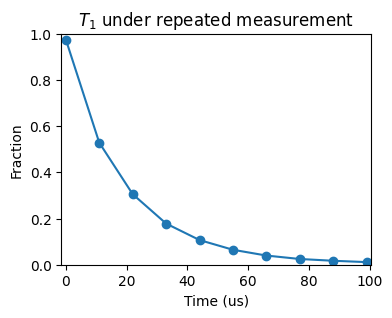

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey = 'row', sharex = 'col')
ax.plot(np.arange(len(np.sum(measurement_outcomes_list, 0))) * (wait_time * 1e6 + 1), np.sum(measurement_outcomes_list, 0) / nr_shots, '-o')

ax.set_ylim(0, 1)
ax.set_xlim(-1.5, max(np.arange(len(np.sum(measurement_outcomes_list, 0))) * (wait_time * 1e6 + 1)) + 1.5)

ax.set_title('$T_1$ under repeated measurement')
ax.set_ylabel('Fraction')
ax.set_xlabel('Time (us)')